before equalization: max/min - 1252.2
after equalization: max/min - 87.0


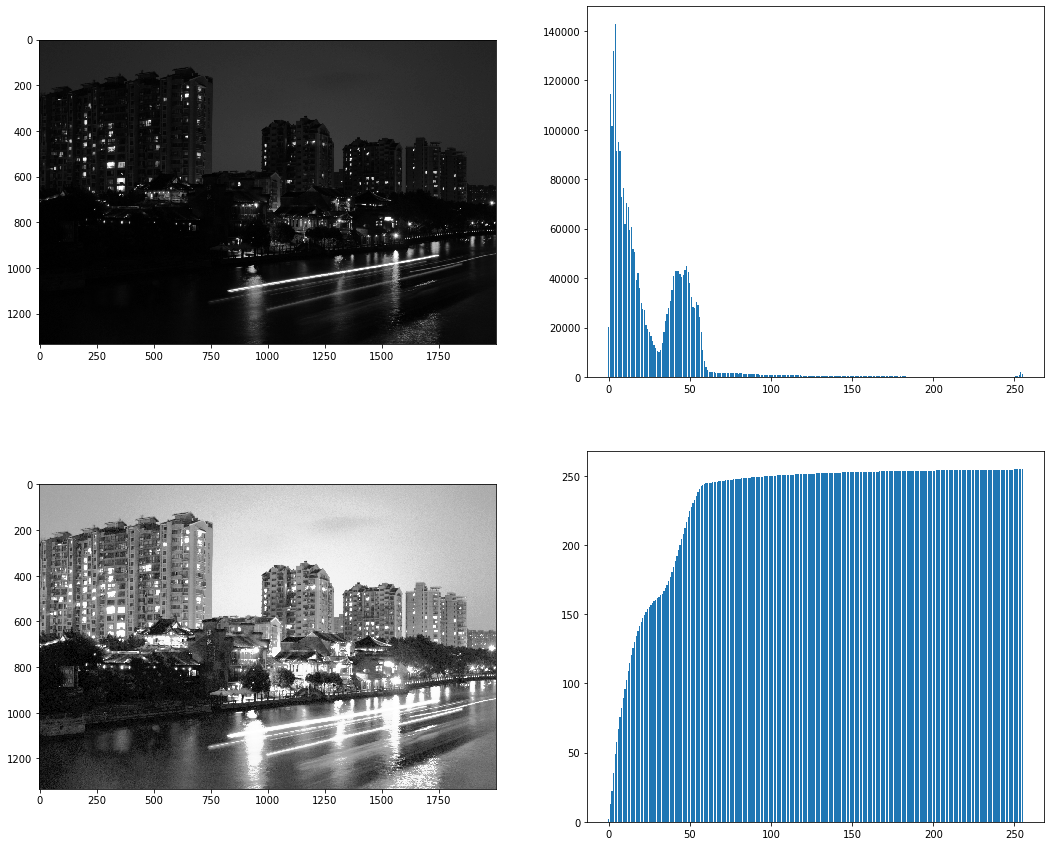

In [7]:
# -*- coding: utf-8 -*-
#
# Wan Xiaolin <xiaolinwancs@gmail.com>
"""
Topics in this notebook:
1. Histogram equalization
2. Gaussian filtering (How to implement convolution in NumPy)
3. Sobel filtering

NumPy functions:
(1) as_strided() ( numpy.lib.stride_tricks.as_strided() )
(2) tensordot()
(3) (not important) pad(), bincount(), histogram(), cumsum(), meshgrid()...

environment requirements:
Python >= 3.7
NumPy >= 1.17
"""
from time import time

import matplotlib.pyplot
import numpy as np
from PIL import Image

FIG_H = 15
FIG_W = 18
DTYPE = 'float32'


# DEMO I: histogram equalization

img = np.array(Image.open('CityView.jpg'), dtype=DTYPE)
img = np.sum(img * np.array([0.2125, 0.7154, 0.0721], dtype=DTYPE), -1)
img = np.round((img - np.min(img)) / np.ptp(img) * 255).astype('uint8')

hist = np.bincount(img.ravel(), minlength=256)
hist_new = np.cumsum(hist / np.sum(hist)) * 255
result = hist_new[img]

print(f'before equalization: max/min - {np.max(hist)/(np.min(hist)+1):.1f}')
print(f'after equalization: max/min - {np.max(hist_new)/(np.min(hist_new)+1):.1f}')

matplotlib.pyplot.figure(figsize=(FIG_W, FIG_H))
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.bar(x=range(len(hist)), height=hist)

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.imshow(result, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.bar(x=range(len(hist_new)), height=hist_new)
matplotlib.pyplot.show()

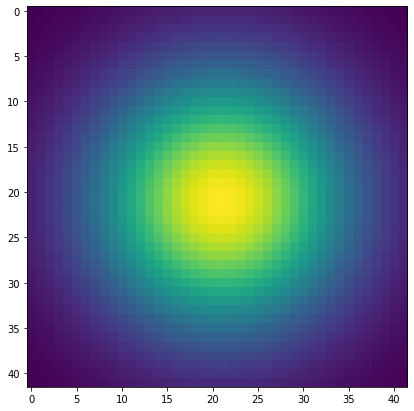

In [2]:
# DEMO II: Gaussian filtering (1)

std = 10
krnl_h = 2 * int(2 * std) + 2
krnl_w = 2 * int(2 * std) + 2

# calculate Gaussian
x, y = np.meshgrid(range(-krnl_w//2, krnl_w//2), range(-krnl_h//2, krnl_h//2))
gaussian_krnl = np.exp(-(x * x + y * y) / (2 * std * std))
gaussian_krnl[gaussian_krnl <= np.finfo(DTYPE).eps * np.max(gaussian_krnl)] = 0
gaussian_krnl /= np.sum(gaussian_krnl)


matplotlib.pyplot.figure(figsize=(FIG_W // 2, FIG_H // 2))
__3d_flag__ = False
if __3d_flag__:
    from mpl_toolkits.mplot3d import axes3d
    _x = np.linspace(-krnl_w//2, krnl_w//2, krnl_h)
    _y = np.linspace(-krnl_h//2, krnl_h//2, krnl_w)
    _x, _y = np.meshgrid(_x, _y)
    matplotlib.pyplot.gca(projection='3d').plot_surface(_x, _y, gaussian_krnl)
    del axes3d
else:
    matplotlib.pyplot.imshow(gaussian_krnl)

matplotlib.pyplot.show()

2d convolution time cost - 2.5067s


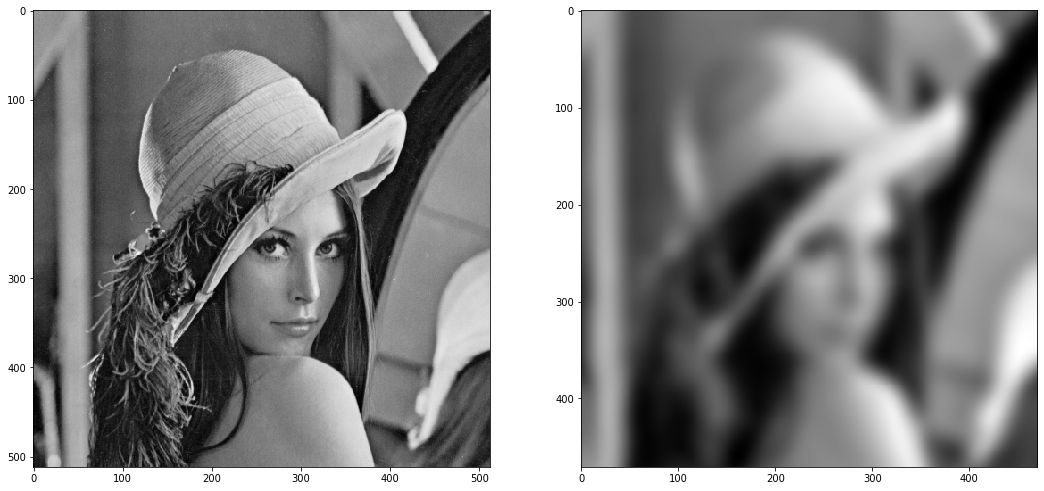

In [3]:
# DEMO II: Gaussian filtering (2)

img = np.array(Image.open('Lenna.png'), dtype=DTYPE)
img = img @ np.array([0.2125, 0.7154, 0.0721], dtype=DTYPE)
img = np.round((img - np.min(img)) / np.ptp(img) * 255).astype('uint8')

# generalized neighbouring operation: as_strided()
start = time()
img_h, img_w = img.shape[:2]
shape = (img_h - krnl_h + 1, img_w - krnl_w + 1, krnl_h, krnl_w)
strides = np.array([img_w, 1, img_w, 1]) * img.itemsize
img_neighoured = np.lib.stride_tricks.as_strided(img, shape, strides)
result = np.sum(np.sum(img_neighoured * gaussian_krnl, -1), -1)
print(f'2d convolution time cost - {time()-start:.4f}s')


matplotlib.pyplot.figure(figsize=(FIG_W, FIG_H))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.imshow(result, cmap='gray')
matplotlib.pyplot.show()

separable convolution time cost - 0.0627s


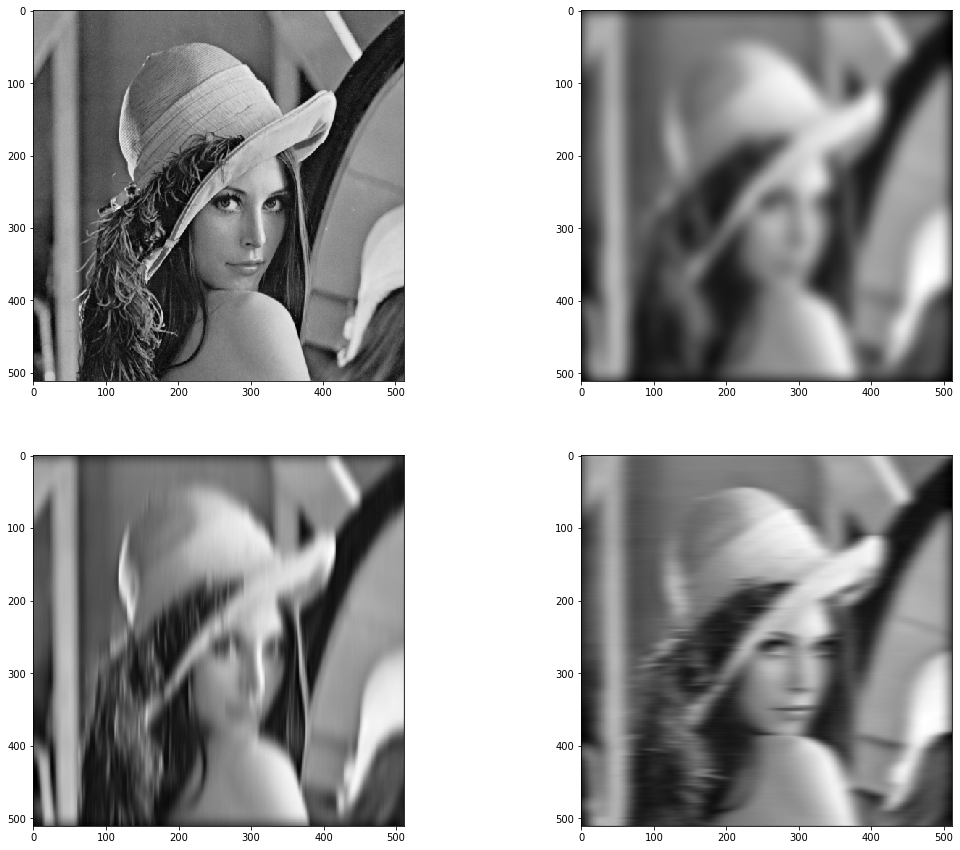

In [4]:
# DEMO II: Gaussian filtering (3)

# warp the function as_strided() and provide a simple API
def conv2d(img, krnl):
    krnl_h, krnl_w = krnl.shape[:2]
    pad_h = (krnl_h - 1) // 2
    pad_w = (krnl_w - 1) // 2
    img = np.pad(img, [(pad_h, pad_h), (pad_w, pad_w)], 'constant')
    img_h, img_w = img.shape[:2]
    shape = (img_h - krnl_h + 1, img_w - krnl_w + 1, krnl_h, krnl_w)
    strides = np.array([img_w, 1, img_w, 1]) * img.itemsize
    img = np.lib.stride_tricks.as_strided(img, shape, strides)
    return np.tensordot(img, krnl, axes=[(2, 3), (0, 1)])

# separable gaussian kernel
def imgaussfilt(img, std_vert=0.5, std_hori=None, dtype='float32'):
    std_hori = std_vert if std_hori is None else std_hori
    x = np.arange(-int(2 * std_hori) - 1, int(2 * std_hori) + 1).astype(dtype)
    y = np.arange(-int(2 * std_vert) - 1, int(2 * std_vert) + 1).astype(dtype)
    krnl_hori = np.exp(-(x * x) / (2 * std_hori * std_hori))
    krnl_hori[krnl_hori < np.finfo(dtype).eps * np.max(krnl_hori)] = 0
    krnl_hori /= np.sum(krnl_hori)
    krnl_vert = np.exp(-(y * y) / (2 * std_vert * std_vert))
    krnl_vert[krnl_vert < np.finfo(dtype).eps * np.max(krnl_vert)] = 0
    krnl_vert /= np.sum(krnl_vert)
    return conv2d(conv2d(img, krnl_hori[None, :]), krnl_vert[:, None])

start = time()
result0 = imgaussfilt(img, 10)
print(f'separable convolution time cost - {time()-start:.4f}s')
result1 = imgaussfilt(img, 10, 0.5)
result2 = imgaussfilt(img, 0.5, 10)


matplotlib.pyplot.figure(figsize=(FIG_W, FIG_H))
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.imshow(result0, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.imshow(result1, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.imshow(result2, cmap='gray')
matplotlib.pyplot.show()

`sobel_h` filter detect horizatal level line and calculate vertical gradient: 
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]],

`sobel_v` filter detect vertical level line and calculate horizatal gradient: 
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]].

2d sobel filtering time cost - 0.0109s
separabel sobel filtering time cost - 0.0041s


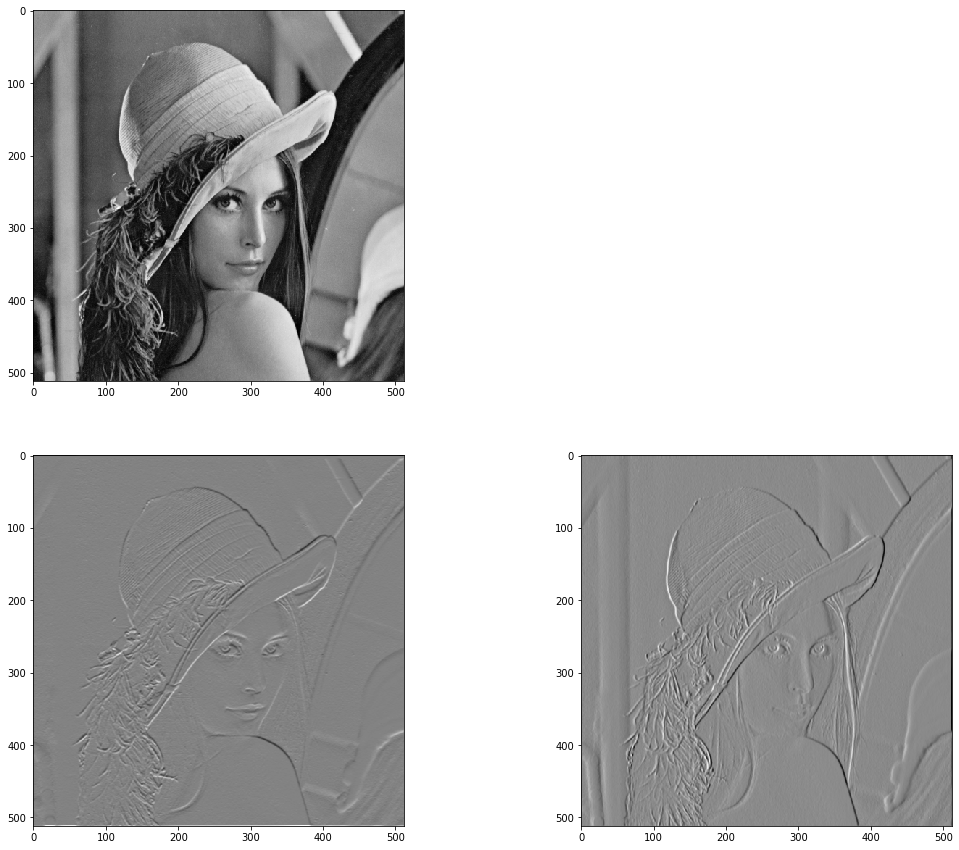

In [5]:
# DEMO III: Sobel filtering
sobel_mean = np.array([1, 2, 1], dtype=DTYPE)

sobel_h = np.array([1, 0, -1], dtype=DTYPE)[:, None] @ sobel_mean[None, :]
print(f'`sobel_h` filter detect horizatal level line', 
      f'and calculate vertical gradient: \n{sobel_h},\n')
sobel_h /= np.sum(np.abs(sobel_h))

sobel_v = sobel_mean[:, None] @ np.array([-1, 0, 1], dtype=DTYPE)[None, :]
print(f'`sobel_v` filter detect vertical level line', 
      f'and calculate horizatal gradient: \n{sobel_v}.\n')
sobel_v /= np.sum(np.abs(sobel_v))

start = time()
horizatal = conv2d(img, sobel_h)
print(f'2d sobel filtering time cost - {time()-start:.4f}s')

start = time()
vertical = conv2d(conv2d(img, sobel_mean[:,None]/4), np.array([-1,0,1], dtype=DTYPE)[None,:]/2)
print(f'separabel sobel filtering time cost - {time()-start:.4f}s')

matplotlib.pyplot.figure(figsize=(FIG_W, FIG_H))
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.imshow(horizatal, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.imshow(vertical, cmap='gray')
matplotlib.pyplot.show()

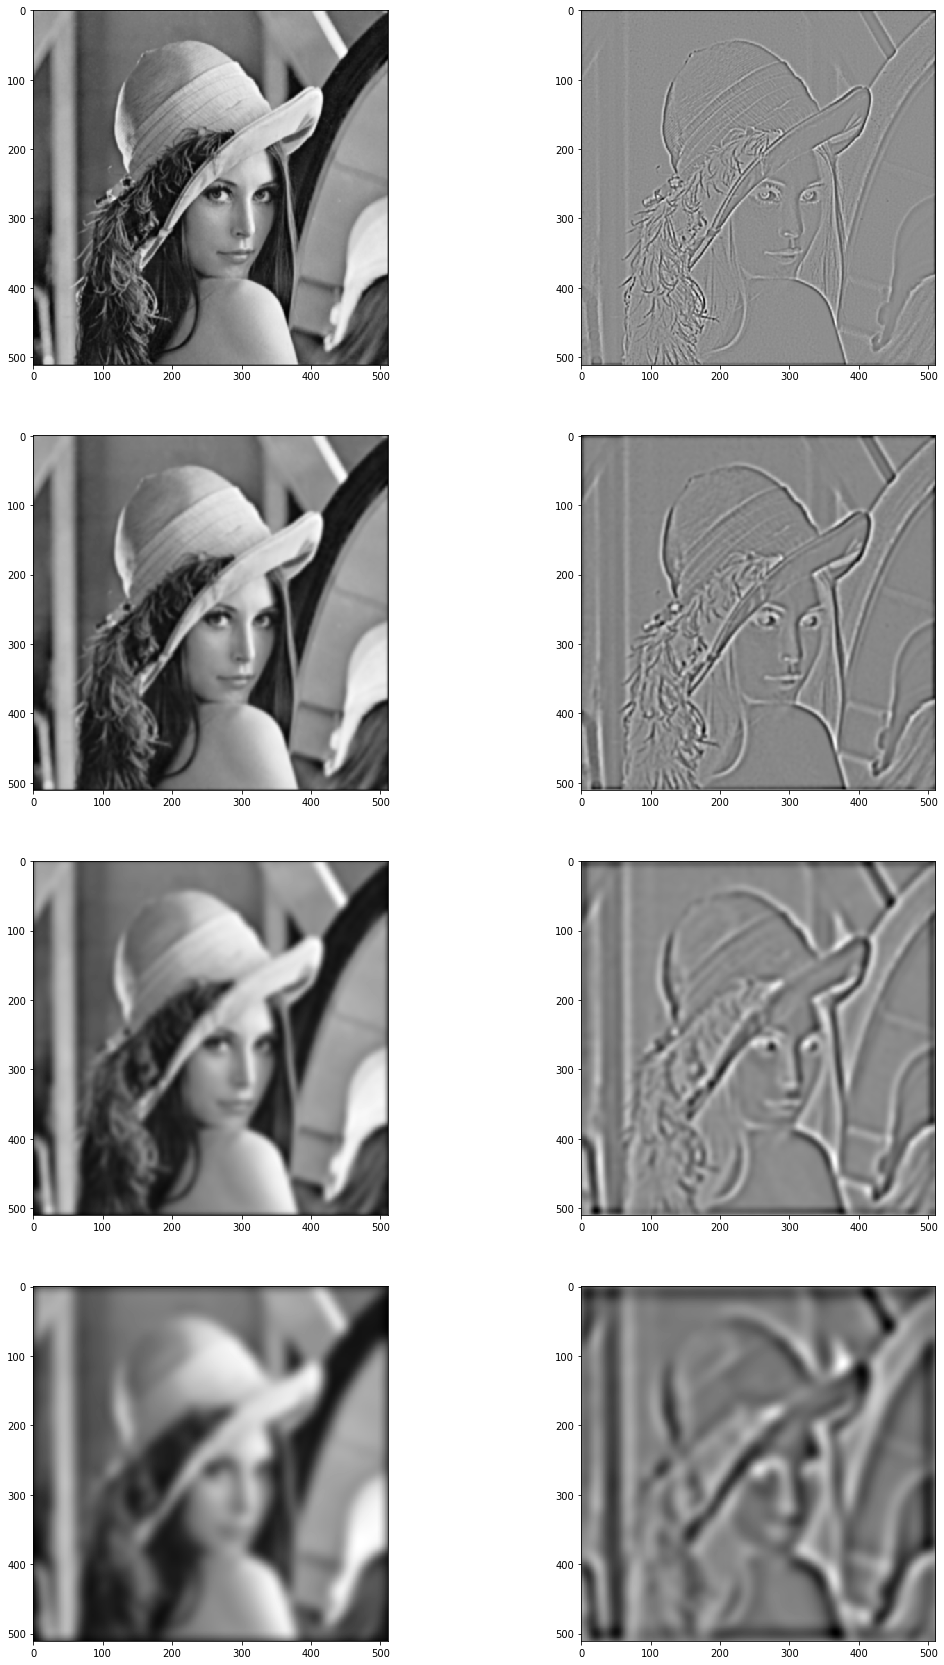

In [6]:
# DEMO IV: image pyramid
n_scales = 4
result_list = [imgaussfilt(img, pow(2, k)) for k in range(n_scales+1)]

matplotlib.pyplot.figure(figsize=(FIG_W, FIG_H * 2))
for k in range(n_scales):
    matplotlib.pyplot.subplot(n_scales, 2, 2*k+1)
    matplotlib.pyplot.imshow(result_list[k], cmap='gray')
    matplotlib.pyplot.subplot(n_scales, 2, 2*k+2)
    matplotlib.pyplot.imshow(result_list[k+1]-result_list[k], cmap='gray')
matplotlib.pyplot.show()
